# Analysis of train dataset

There is something suspect in the distribution of duplicates related to id (the id of each pair)

In [2]:
# Ugly incantation to make our framework working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='louche'
print_alert('You will work on environment %s' %EXPERIMENT)
prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)

* Cut training dataset into centiles
* For each centile, find the % of duplicates
* Graph it

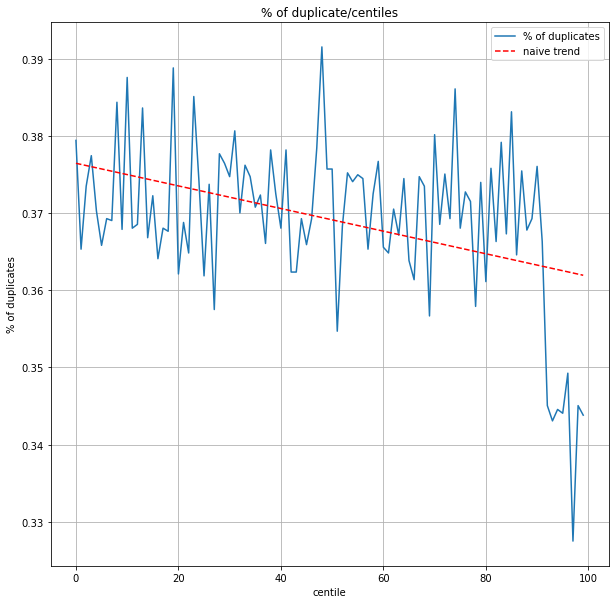

In [3]:
from scipy.interpolate import interp1d

# Generate the centiles
train_dataframe['centile']=pandas.qcut(train_dataframe['id'],q=100,precision=0,labels=False)
# Count the duplicates for each centile
nb_duplicate_centiles=train_dataframe.groupby(['centile'])['is_duplicate'].sum()/train_dataframe.groupby(['centile'])['is_duplicate'].count()

# Compute a naive trend just to see ...
t=numpy.polyfit(train_dataframe['centile'].unique(),nb_duplicate_centiles,1)
p=numpy.poly1d(t)

plot.figure(figsize=(10,10))
plot.plot(train_dataframe['centile'].unique(),nb_duplicate_centiles,label='% of duplicates')
plot.plot(train_dataframe['centile'].unique(),p(train_dataframe['centile'].unique()),'r--',label='naive trend')
plot.xlabel('centile')
plot.ylabel('% of duplicates')
plot.title('% of duplicate/centiles')
plot.legend()
plot.grid(True)
plot_save('trend_id')


Looks like repartition of is_duplicate is not uniform in the training...

It can be because Quora's guys are also working on models and the **is_duplicate** label is a reflect of the improvement on their models...

Let's do some simple test to see if this time series is stationary or not
### Augmented Dickey-Fuller Unit Root Test

In [4]:
from statsmodels.tsa.stattools import adfuller
stat, p, lags, obs, crit, t = adfuller(nb_duplicate_centiles)
print_warning('Augmented Dickey-Fuller Unit Root Test stat=%.3f, p=%.3f' % (stat, p))
print_warning( 'Critical values:')
for key, value in crit.items():
	print_warning('\t%s: %.3f' % (key, value))
if p > 0.05:
	print_alert('H0: "a unit root is present" is accepted: Probably Not Stationary!!')
else:
	print_info('H1: "a unit root is present" is rejected: Probably Stationary')

### Kwiatkowski-Phillips-Schmidt-Shin Test


In [5]:
from statsmodels.tsa.stattools import kpss

stat, p, lags, crit = kpss(nb_duplicate_centiles)
print_warning('Kwiatkowski-Phillips-Schmidt-Shin Test stat=%.3f, p=%.3f' % (stat, p))
print_warning( 'Critical values:')
for key, value in crit.items():
	print_warning('\t%s: %.3f' % (key, value))
if p > 0.05:
	print_alert('H0: "the time series is not trend-stationary" is accepted: Probably Not Stationary!!')
else:
	print_info('H1: "the time series is not trend-stationary" is rejected: Probably Stationary')

